# <center>**Facial Expression Recognition**</center>



# Context of the Project:
 [**RAF-DB (Real-World Affective Face Database)**]

Facial emotion recognition (FER) is a subfield of computer vision that focuses on identifying human emotions from facial expressions. Recognizing emotions from faces has practical applications in fields such as:

* **Customer service:** Analyzing customer satisfaction in real-time.
* **Security:** Identifying suspicious or threatening individuals.
* **Healthcare:** Monitoring emotional states in patients, especially those with mental health conditions.
* **Human-robot interaction:** Improving communication between humans and robots.

The challenge in this project is the imbalance in the classes, as some emotions are more prevalent than others, which can affect the performance of models trained on such data.

# Objective of the Project:

The main objective of this notebook is to classify the facial expressions from the RAF-DB dataset into seven categories based on the emotions they represent. Specifically, the objectives include:

1.  **Preprocess the data:** This involves loading, resizing, and normalizing images while addressing class imbalance (e.g., some emotions may be underrepresented in the dataset).

2. **Build and model:** The project will involve training of
    * **CNN (Convolutional Neural Network) :** A deep learning model that can automatically learn features from images and will be evaluated for its ability to classify emotions.


# <p style="color:white;background-color:#E17A8A;font-family:newtimeroman;font-size:130%;text-align:center;border-radius:50px 10px;">data understanding</p>

In [1]:
import os
import cv2
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, RocCurveDisplay, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer,LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.svm import LinearSVC

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.applications import DenseNet121
from sklearn.metrics import roc_curve, auc

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from keras.backend import clear_session
import gc


In [2]:
# Load the labels CSV files
train_labels = pd.read_csv('filtered_train_labelss.csv')
test_labels = pd.read_csv('filtered_test_labelss.csv')

# Display the first few rows of the train labels to check the structure
print(train_labels.head())

classes = ['surprise','unsatisfied','happy', 'sad', 'angry', 'neutral']


label_map = {label: (idx+1) for idx, label in enumerate(classes)}

print(label_map)

                     image  label
0  train_00001_aligned.jpg      4
1  train_00002_aligned.jpg      4
2  train_00003_aligned.jpg      3
3  train_00004_aligned.jpg      3
4  train_00005_aligned.jpg      4
{'surprise': 1, 'unsatisfied': 2, 'happy': 3, 'sad': 4, 'angry': 5, 'neutral': 6}


In [3]:
# Function to load images and labels from the directory
def load_data(dataset_dir, label_map):
    images = []
    labels = []
    
    for label, idx in tqdm(label_map.items()):
        folder_path = os.path.join(dataset_dir, str(idx))  # +1 because folder names start from '1'
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img_rgb)
            labels.append(idx)
    
    return np.array(images), np.array(labels)

# Load train and test datasets
train_images, train_labels = load_data('DATASET/train', label_map)
test_images, test_labels = load_data('DATASET/test', label_map)
print(train_images.shape)
print(test_images.shape)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

(11990, 100, 100, 3)
(2994, 100, 100, 3)


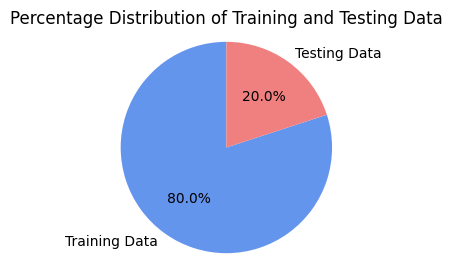

In [4]:
# Calculate the total number of images
total_images = len(train_images) + len(test_images)

# Calculate percentages
train_percentage = (len(train_images) / total_images) * 100
test_percentage = (len(test_images) / total_images) * 100

# Data for pie chart
labels = ['Training Data', 'Testing Data']
sizes = [train_percentage, test_percentage]
colors = ['cornflowerblue', 'lightcoral']

# Plot the pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage Distribution of Training and Testing Data')
plt.axis('equal')  
plt.show()


train_label_counts  Counter({3: 4772, 6: 2524, 4: 1982, 1: 1290, 2: 717, 5: 705})
test_counts [329, 160, 1185, 478, 162, 680]


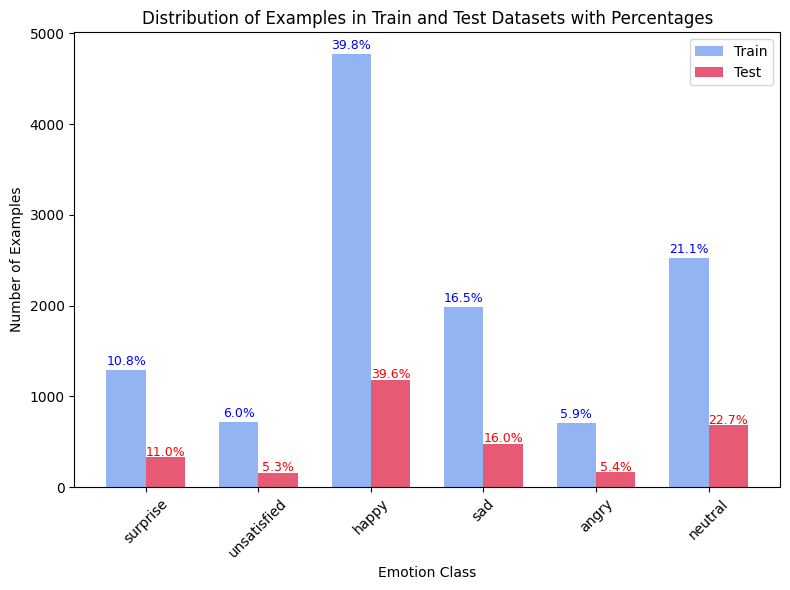

In [5]:
# Count the distribution of classes in train and test datasets
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)
print('train_label_counts ',train_label_counts)
# Convert to sorted lists for plotting
train_classes = sorted(train_label_counts.keys())
train_counts = [train_label_counts[cls] for cls in train_classes]

test_classes = sorted(test_label_counts.keys())
test_counts = [test_label_counts[cls] for cls in test_classes]
print('test_counts',test_counts)
# Calculate the total number of examples in train and test datasets
total_train = sum(train_counts)
total_test = sum(test_counts)

# Calculate percentages for train and test datasets
train_percentages = [(count / total_train) * 100 for count in train_counts]
test_percentages = [(count / total_test) * 100 for count in test_counts]

# Plot the distribution with percentages
plt.figure(figsize=(8, 6))
x = range(len(classes))
bar_width = 0.35

plt.bar(x, train_counts, width=bar_width, label="Train", alpha=0.7, color="cornflowerblue")
plt.bar([p + bar_width for p in x], test_counts, width=bar_width, label="Test", alpha=0.7, color="crimson")

# Annotate percentages on bars
for i, (train_count, test_count) in enumerate(zip(train_counts, test_counts)):
    plt.text(i, train_count + 0.005 * total_train, f"{train_percentages[i]:.1f}%", ha='center', color="blue", fontsize=9)
    plt.text(i + bar_width, test_count + 0.005 * total_test, f"{test_percentages[i]:.1f}%", ha='center', color="red", fontsize=9)

# Add labels and title
plt.xticks([p + bar_width / 2 for p in x], classes, rotation=45)
plt.xlabel("Emotion Class")
plt.ylabel("Number of Examples")
plt.title("Distribution of Examples in Train and Test Datasets with Percentages")
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

> The dataset shows a clear class imbalance, with **Happy** being the dominant class (39,9%) and **Fear** and **Angry** being underrepresented (2,3% and 5,7%). This imbalance may lead the model to favor the majority class, causing poor performance for minority classes. The distribution is consistent across train and test sets, but techniques like class weighting, oversampling, or data augmentation are needed to address this imbalance and improve model performance.

In [6]:
# Combine the train and test datasets into the same variables
X_train = np.concatenate([train_images, test_images], axis=0)
Y_train = np.concatenate([train_labels, test_labels], axis=0)

# Display the shapes to confirm
print(X_train.shape)
print(Y_train.shape)

(14984, 100, 100, 3)
(14984,)



> To simplify the preprocessing steps, the training and testing datasets are merged into a single dataset.
> This is achieved by **concatenating** the images (train_images and test_images) and their corresponding labels (train_labels and test_labels) along the first axis, creating unified variables for further processing.
> 
> This combined dataset will allow for unified data augmentation and preprocessing steps before splitting it again for model training and evaluation. The shapes of the resulting arrays are displayed to verify the merge."


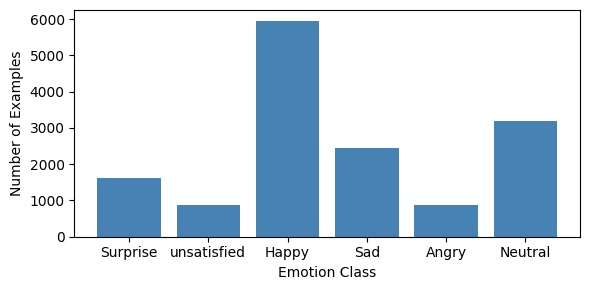

In [7]:
# Count the distribution of classes in the resampled train dataset
train_label_counts_resampled = Counter(Y_train)
    
# Convert to sorted lists for plotting
train_classes_resampled = sorted(train_label_counts_resampled.keys())
train_counts_resampled = [train_label_counts_resampled[cls] for cls in train_classes_resampled]
# Plot the distribution
plt.figure(figsize=(6, 3))
x_labels = ['Surprise','unsatisfied','Happy', 'Sad', 'Angry', 'Neutral']
    
# Bar plot for the resampled distribution
plt.bar(x_labels, train_counts_resampled, color="steelblue")
    
# Add labels and title
plt.xlabel("Emotion Class")
plt.ylabel("Number of Examples")
plt.title('')
plt.tight_layout()
    
# Show the plot
plt.show()

In [8]:
# Shuffle X_train and Y_train
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

# Display the shapes to confirm the data is shuffled
print(X_train.shape)
print(Y_train.shape)

(14984, 100, 100, 3)
(14984,)


> To ensure the training data is presented to the model in a random order, we shuffle the **X_train** and **Y_train** datasets using a fixed random state for reproducibility. This step helps prevent the model from learning any unintended patterns from the data ordering, improving the overall training process. 

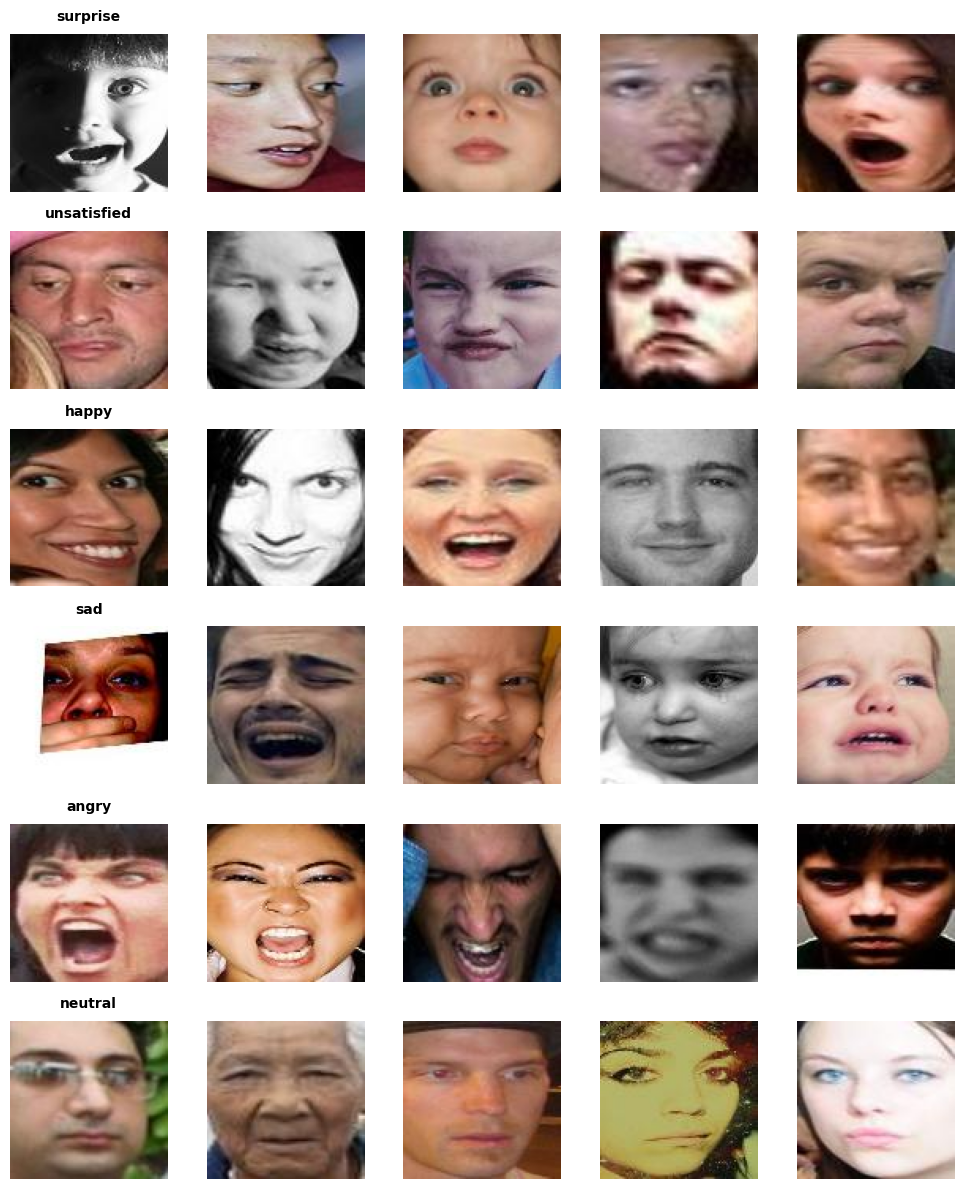

In [9]:
def show_examples(train_images, train_labels, labels, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 12))
    
    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(train_labels) if label == i+1]
        selected_indices = np.random.choice(class_indices, num_examples, replace=False)
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')
        # Display the random images for the current class
        for j, idx in enumerate(selected_indices):
            img = train_images[idx]
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample images for each class
show_examples(X_train, Y_train, classes)

In [10]:
# most frequent image sizes :
train_data_shapes = []
for img in X_train:
  train_data_shapes.append(img.shape)
# Count occurrences for each size
shape_counts = {}
for shape in train_data_shapes:
  if shape not in shape_counts:
    shape_counts[shape] = 0
  shape_counts[shape] += 1
# Sort shapes by count
sorted_shapes = sorted(shape_counts.items(), key=lambda x: x[1], reverse=True)
# show most frequent size
print("Most frequent Train images shapes:")
for shape, count in sorted_shapes[:3]:
  print(f"- {shape}: {count}")

Most frequent Train images shapes:
- (100, 100, 3): 14984


> The most frequent image shape in the training dataset is **(100, 100, 3)**, with **12,271** images in this resolution. Since the majority of the dataset already has a consistent size of **100x100 pixels** with three color channels (RGB), there is no need to resize the images. Maintaining their original dimensions avoids unnecessary computational overhead and preserves the quality and features of the data. This consistency simplifies preprocessing and ensures the model receives inputs in their native resolution, which can lead to better feature extraction and improved model performance.

# <p style="color:white;background-color:#E17A8A;font-family:newtimeroman;font-size:130%;text-align:center;border-radius:50px 10px;">data preparation</p>



**1. Oversampling**

> In this notebook, we address class **imbalance** by applying oversampling techniques. First, we **reduce** the size of the **'happy'** class to a target count using random sampling. Then, we **augment** the classes with fewer samples by generating additional images through data augmentation techniques such as rotation, translation, zooming, and horizontal flipping. This ensures a balanced distribution of classes, making the model training more robust and improving its performance on underrepresented classes. The final dataset distribution is visualized after both the reduction and augmentation processes to confirm the effectiveness of these techniques.

In [14]:
# Function to plot the class distribution
def plot_class_distribution(y, title):
    # Count the distribution of classes in the resampled train dataset
    train_label_counts_resampled = Counter(y)
    
    # Convert to sorted lists for plotting
    train_classes_resampled = sorted(train_label_counts_resampled.keys())
    train_counts_resampled = [train_label_counts_resampled[cls] for cls in train_classes_resampled]
    
    # Plot the distribution
    plt.figure(figsize=(6, 3))
    x_labels = ['Surprise','unsatisfied','Happy', 'Sad', 'Angry', 'Neutral']
    
    # Bar plot for the resampled distribution
    plt.bar(x_labels, train_counts_resampled, color="steelblue")
    
    # Add labels and title
    plt.xlabel("Emotion Class")
    plt.ylabel("Number of Examples")
    plt.title(title)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

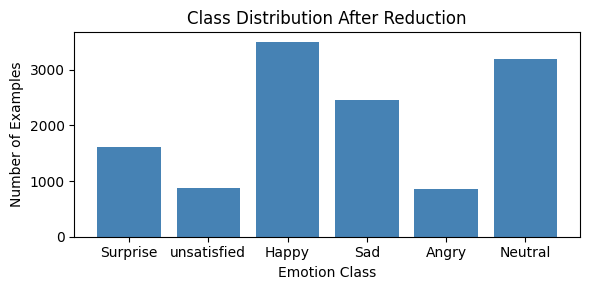

In [15]:
# Function to reduce the size of a specific class in the dataset
def reduce_class(X, y, target_class, target_size):
    # Separate the target class
    class_indices = np.where(y == target_class)[0]
    non_class_indices = np.where(y != target_class)[0]
    
    # Randomly sample the target class to the desired size
    reduced_class_indices = np.random.choice(class_indices, target_size, replace=False)
    
    # Combine the reduced class with the other classes
    final_indices = np.concatenate([reduced_class_indices, non_class_indices])
    X_reduced = X[final_indices]
    y_reduced = y[final_indices]
    
    return X_reduced, y_reduced

target_class = 3  # The 'happy' class
target_size = 3500
X_train_reduced, y_train_reduced = reduce_class(X_train, Y_train, target_class, target_size)
# Plot the new distribution after reduction
plot_class_distribution(y_train_reduced, "Class Distribution After Reduction")

Class 1: 1619 samples augmented with 1881 additional samples.
Class 2: 877 samples augmented with 2623 additional samples.
Class 4: 2460 samples augmented with 1040 additional samples.
Class 5: 867 samples augmented with 2633 additional samples.
Class 6: 3204 samples augmented with 296 additional samples.


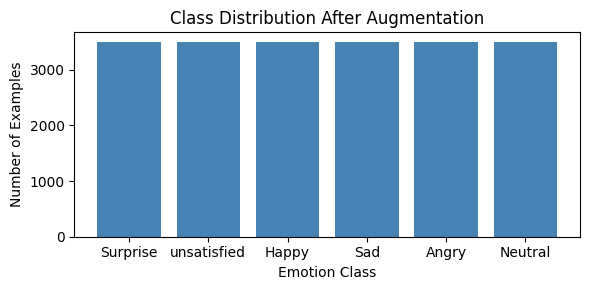

In [17]:
def augment_classes(images, labels, target_counts):
    # Initialize image augmentation
    datagen = ImageDataGenerator(
        rotation_range=10,             
        width_shift_range=0.1,         
        height_shift_range=0.1,  
        zoom_range=0.1,

        vertical_flip=False,               
        horizontal_flip=True, 
        channel_shift_range=50.0,
        fill_mode='nearest'
    )

    augmented_images = images.copy()  # Copy the images to preserve the original dataset
    augmented_labels = labels.copy()  # Copy the labels as well

    # For each class, increase the number of samples
    for target_class, target_count in target_counts.items():
        # Filter images and labels for the target class
        class_images = images[labels == target_class]
        class_labels = labels[labels == target_class]
        # Calculate the number of samples to generate
        augment_count = target_count - len(class_images)

        if augment_count > 0:
            print(f'Class {target_class}: {len(class_images)} samples augmented with {augment_count} additional samples.')

            # Create an iterator for the target class
            class_images_augmented = []
            class_labels_augmented = []

            # Apply augmentation iteratively
            for batch in datagen.flow(class_images, batch_size=1, seed=42):
                aug_image = batch[0].astype(np.uint8)
                class_images_augmented.append(aug_image)
                class_labels_augmented.append(target_class)
                
                # Stop when the desired number of augmented images is reached
                if len(class_images_augmented) >= augment_count:
                    break
            
            # Add the augmented images to the original dataset
            augmented_images = np.vstack((augmented_images, np.array(class_images_augmented)))
            augmented_labels = np.hstack((augmented_labels, np.array(class_labels_augmented)))

    return augmented_images, augmented_labels

# Example usage
target_counts = {1: 3500, 2: 3500, 4: 3500, 5: 3500,6: 3500}  # Target counts for each class
X_train_augmented, y_train_augmented = augment_classes(X_train_reduced, y_train_reduced, target_counts)

# Visualize the class distribution after augmentation
plot_class_distribution(y_train_augmented, "Class Distribution After Augmentation")


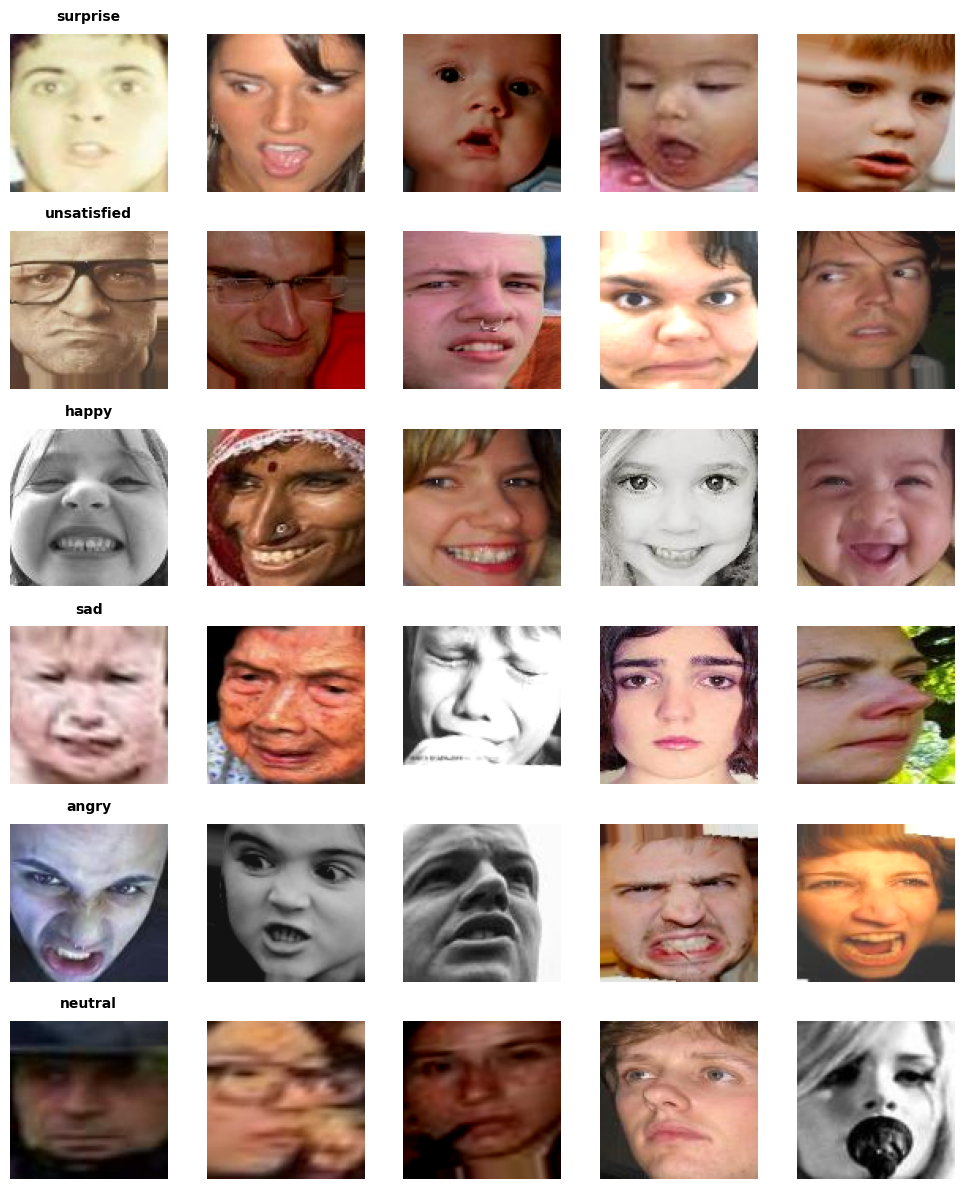

In [17]:
# Show sample images for each class
show_examples(X_train_augmented, y_train_augmented, classes)

**Split**



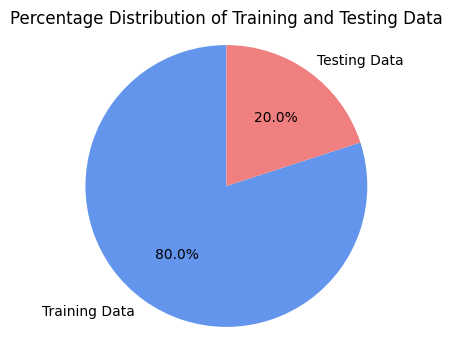

In [18]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Splitting data with stratification
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_augmented, 
    y_train_augmented, 
    test_size=0.20, 
    shuffle=True,
    stratify=y_train_augmented,  # Stratified Sampling
    random_state=42
)

# Calculate total images after splitting
total_images = len(X_train) + len(X_test)

# Calculate precentages
train_percentage = (len(X_train) / total_images) * 100
test_percentage = (len(X_test) / total_images) * 100

# Pie cahrt 
labels = ['Training Data', 'Testing Data']
sizes = [train_percentage, test_percentage]
colors = ['cornflowerblue', 'lightcoral']

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage Distribution of Training and Testing Data')
plt.axis('equal')  
plt.show()


> The dataset is split into training and testing sets, with 80% allocated for training and 20% for testing, using the train_test_split function. TThis separation is crucial for evaluating the model's generalization ability on unseen data.

**2. Normalize the images**

In [19]:
def normalize_images(images):
    # Normalize pixel values to [0, 1]
    return images / 255.0

train_images_normalized = normalize_images(X_train)
test_images_normalized = normalize_images(X_test)

> To standardize the pixel values and ensure consistent input for the model, the image data is normalized by scaling the pixel values to a **range of [0, 1]**. This is achieved by dividing the pixel values by 255, the maximum pixel value for an 8-bit image. Both the training and testing images are normalized using this approach to facilitate better model performance and faster convergence during training.

**3. Reshape the images**

In [20]:
def reshape_images(images):
        # CNN and DenseNet require images to have shape (height, width, channels)
        return images.reshape((images.shape[0], 100, 100, 3))



train_images_CNNreshaped = reshape_images(train_images_normalized)
test_images_CNNreshaped = reshape_images(test_images_normalized)

> In this step, the images are reshaped to fit the requirements of different models.
> * For the Support Vector Machine (SVM), the images are flattened into one-dimensional arrays, as SVM models expect feature vectors as input.
> * On the other hand, for Convolutional Neural Networks (CNN) and models like DenseNet, the images are reshaped to maintain their spatial structure, with dimensions corresponding to height, width, and color channels.
>   
> This reshaping ensures that the images are in the correct format for each model type and can be effectively processed during training and testing.


**6. Convert labels to categorical**

In [21]:
# Convert labels to categorical for CNN
Y_train_cat = to_categorical(Y_train - 1, num_classes=len(classes))
Y_test_cat = to_categorical(Y_test - 1, num_classes=len(classes))

> The labels are converted to one-hot encoded format, adjusting them by subtracting 1 to match the index range. This conversion is crucial for models like CNN, which require the target labels to be in a categorical format (as vectors) to compute the loss function during training and evaluation. The number of categories is defined by the total number of classes in the dataset."

**4. Data Augmentation for CNN and DenseNet**

In [22]:
datagen = ImageDataGenerator(
    rotation_range=20,             
    width_shift_range=0.1,         
    height_shift_range=0.1,  
    vertical_flip=False,               
    horizontal_flip=True, 
    fill_mode='nearest'
)

# Create the generator for training
train_generator = datagen.flow(train_images_CNNreshaped, Y_train_cat, batch_size=64)

> To enhance the model's ability to generalize, data augmentation is applied using **ImageDataGenerator**. This involves applying random transformations, which helps the model become more robust to variations in the input images. 

# <p style="color:white;background-color:#E17A8A;font-family:newtimeroman;font-size:130%;text-align:center;border-radius:50px 10px;">CNN Model</p>

**CNN model**

In [28]:
# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(test_images_CNNreshaped[0].shape)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(len(classes), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 8, 8, 512)           │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,881,478 (18.62 MB)

 Trainable params: 4,881,478 (18.62 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train the CNN model
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_delta=0.0001, verbose=1) 
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)  
checkpoint = ModelCheckpoint(filepath='best_CNNModel.keras', monitor='val_accuracy', save_best_only=True, verbose=1) 

CNN_History = cnn_model.fit(
    train_generator,
    epochs=70, 
    validation_data=(test_images_CNNreshaped, Y_test_cat), 
    callbacks=[reduce_lr, early_stop, checkpoint]
)


Epoch 1/70
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.2089 - loss: 1.7629
Epoch 1: val_accuracy improved from -inf to 0.38048, saving model to best_CNNModel.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 47s 173ms/step - accuracy: 0.2090 - loss: 1.7627 - val_accuracy: 0.3805 - val_loss: 1.5689 - learning_rate: 0.0010
Epoch 2/70
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.3688 - loss: 1.5618
Epoch 2: val_accuracy improved from 0.38048 to 0.51143, saving model to best_CNNModel.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 45s 172ms/step - accuracy: 0.3690 - loss: 1.5615 - val_accuracy: 0.5114 - val_loss: 1.2468 - learning_rate: 0.0010
Epoch 3/70
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.4776 - loss: 1.3343
Epoch 3: val_accuracy improved from 0.51143 to 0.58833, saving model to best_CNNModel.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 45s 170ms/step - accuracy: 0.4777 - loss: 1.3342 - val_accuracy: 0.5883 - val_loss: 1.0563 - learning_rate: 0.0010
Epoch 4/70
263/263 ━━━━━━━━━━━━

In [30]:
CNN_History.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

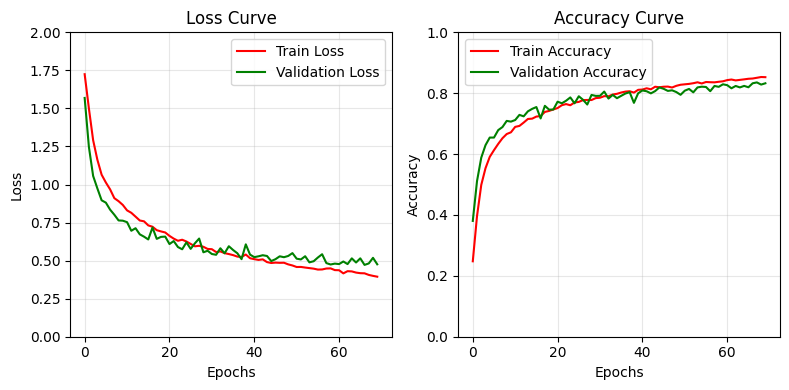

In [31]:
train_loss = CNN_History.history['loss']
val_loss = CNN_History.history['val_loss']
train_accuracy = CNN_History.history['accuracy']
val_accuracy = CNN_History.history['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(train_loss, label='Train Loss', color='red')
ax[0].plot(val_loss, label='Validation Loss', color='green')
ax[0].set_title('Loss Curve')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_ylim([0, 2])
ax[0].grid(alpha=0.3)

ax[1].plot(train_accuracy, label='Train Accuracy', color='red')
ax[1].plot(val_accuracy, label='Validation Accuracy', color='green')
ax[1].set_title('Accuracy Curve')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim([0, 1])
ax[1].grid(alpha=0.3)

# Ajuster l'espacement entre les sous-graphes
plt.tight_layout()
plt.show()

In [32]:
train_CNNresult = cnn_model.evaluate(train_images_CNNreshaped, Y_train_cat)
test_CNNresult = cnn_model.evaluate(test_images_CNNreshaped, Y_test_cat)

# Evaluate the CNN model
print("Train Loss: {:.2f}%".format(train_CNNresult[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_CNNresult[1] * 100))

print("\nTest Loss: {:.2f}%".format(test_CNNresult[0] * 100))
print("Test Accuracy: {:.2f}%".format(test_CNNresult[1] * 100))

525/525 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.9098 - loss: 0.2381
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8400 - loss: 0.4659
Train Loss: 22.79%
Train Accuracy: 91.59%

Test Loss: 48.15%
Test Accuracy: 83.55%


In [33]:
# Predict on the test set
y_predCNN_prob = cnn_model.predict(test_images_CNNreshaped)  # Predict probabilities
y_predCNN = np.argmax(y_predCNN_prob, axis=1)   # Convert to class labels
y_true = np.argmax(Y_test_cat, axis=1)   # Convert one-hot encoded labels to class indices

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_predCNN, target_names=classes))

132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step
Classification Report:
              precision    recall  f1-score   support

    surprise       0.90      0.89      0.89       700
 unsatisfied       0.79      0.84      0.82       700
       happy       0.93      0.85      0.89       700
         sad       0.79      0.76      0.77       700
       angry       0.92      0.90      0.91       700
     neutral       0.70      0.77      0.74       700

    accuracy                           0.84      4200
   macro avg       0.84      0.84      0.84      4200
weighted avg       0.84      0.84      0.84      4200



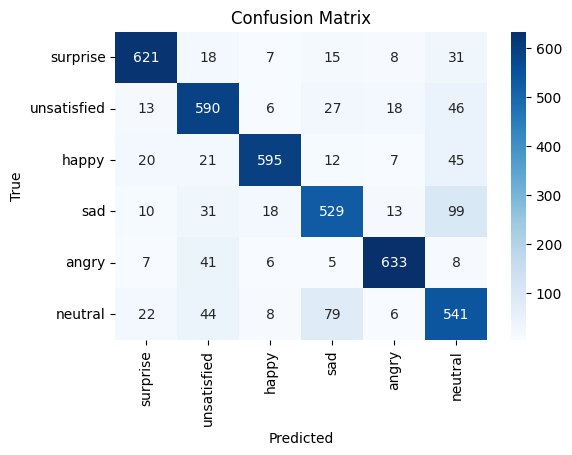

In [34]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_predCNN)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

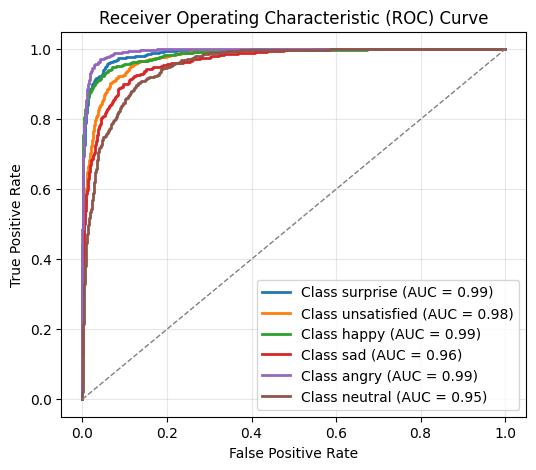

In [35]:
# Binarize the true labels for multi-class ROC computation
y_true_bin = label_binarize(y_true, classes=list(range(len(classes))))

# Initialisation des FPR, TPR, et AUC pour chaque classe
fpr = {}
tpr = {}
roc_auc = {}

# Calcul des courbes ROC et de l'AUC pour chaque classe
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_predCNN_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer toutes les courbes ROC
plt.figure(figsize=(6, 5))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Ligne de référence pour une prédiction aléatoire
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

# Personnalisation du graphique
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

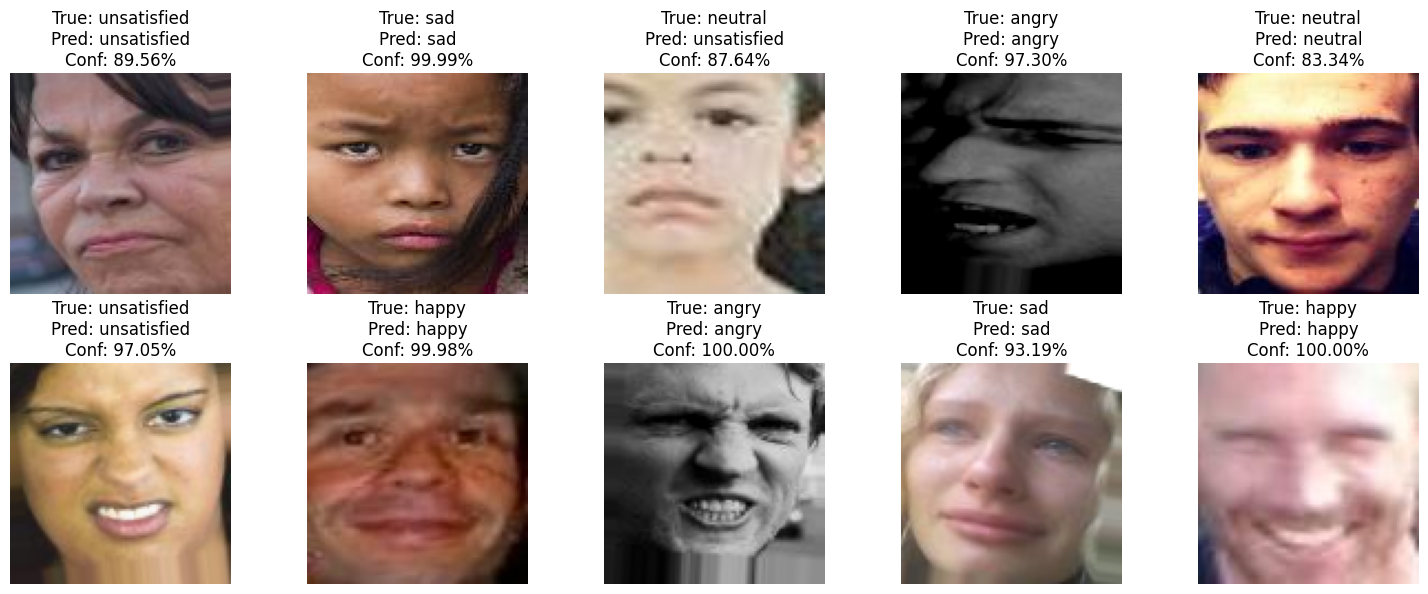

In [37]:
random_indices = np.random.choice(len(test_images_CNNreshaped), 10, replace=False)

fig, ax = plt.subplots(2, 5, figsize=(15, 6))

for i, idx in enumerate(random_indices):
    image = test_images_CNNreshaped[idx]
    true_class = classes[Y_test[idx] - 1]  
    pred_class = classes[y_predCNN[idx]]  
    confidence = np.max(y_predCNN_prob[idx]) * 100   
    
    # Plotting
    ax[i // 5, i % 5].imshow(image)
    ax[i // 5, i % 5].axis('off')  
    ax[i // 5, i % 5].set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}%')

plt.tight_layout()
plt.show()

# <p style="color:white;background-color:#E17A8A;font-family:newtimeroman;font-size:130%;text-align:center;border-radius:50px 10px;">Save the best model</p>

In [38]:

cnn_accuracy = test_CNNresult[1] * 100

cnn_accuracy


83.54762196540833

In [39]:
cnn_model.save('best_model122.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Prediction Shape: (1, 6)
Prediction Values: [[1.2217945e-06 8.9144652e-07 9.9662638e-01 3.2835342e-03 7.3787141e-06
  8.0654325e-05]]


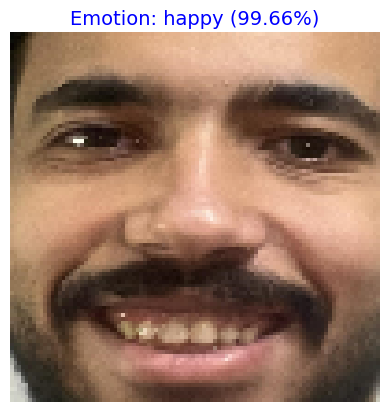


Confidence Scores for Each Emotion:
surprise: 0.00%
unsatisfied: 0.00%
happy: 99.66%
unsatisfied: 0.33%
angry: 0.00%
neutral: 0.01%

Final Prediction: happy with 99.66% confidence


In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

# Load the trained model
cnn_model = load_model("best_model122.h5")

# Emotion class dictionary
class_dict = {1: "surprise",2:"unsatisfied",3: "happy", 4: "unsatisfied", 5: "angry", 6: "neutral"}

# Preprocess the image
def preprocess_image(image_path, target_size=(100, 100)):  
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)  # Ensure input is 4D
    image_array = image_array / 255.0
    return image_rgb, image_array

# Predict emotions and display results
def predict_and_display(image_path):
    image_rgb, image_array = preprocess_image(image_path)

    # Run predictions
    prediction = cnn_model.predict(image_array)

    # Print prediction details
    print("Prediction Shape:", prediction.shape)
    print("Prediction Values:", prediction)

    # Reshape prediction if needed
    prediction = prediction.reshape(1, -1)

    # Extract the predicted emotion
    emotion_label = np.argmax(prediction) + 1  # Adjust index to match the dictionary
    predicted_emotion = class_dict.get(emotion_label, "Unknown")  
    confidence = prediction[0][emotion_label - 1] * 100  

    # Display the image with prediction
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(f"Emotion: {predicted_emotion} ({confidence:.2f}%)", fontsize=14, color='blue')
    plt.show()

    # Print confidence scores for all emotions
    print("\nConfidence Scores for Each Emotion:")
    for i, (key, emotion) in enumerate(class_dict.items()):
        print(f"{emotion}: {prediction[0][i] * 100:.2f}%")

    return predicted_emotion, confidence

# Run prediction on a sample image
image_path = "you.jpg"
predicted_emotion, confidence_score = predict_and_display(image_path)

if predicted_emotion != "Unknown":
    print(f"\nFinal Prediction: {predicted_emotion} with {confidence_score:.2f}% confidence")
else:
    print("\n⚠ The model could not classify the image correctly.")


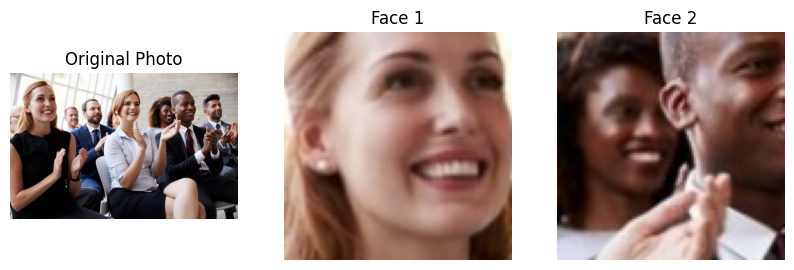

In [41]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# Load Mediapipe Face Detection model
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# Function to extract faces from an image
def extract_faces(image_path, target_size=(100, 100)):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    
    with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detector:
        results = face_detector.process(image_rgb)

        if not results.detections:
            print(" No faces detected!")
            return None, image_rgb

        faces = []
        for detection in results.detections:
            bboxC = detection.location_data.relative_bounding_box
            h, w, _ = image.shape

            # Extract face coordinates
            x_min = int(bboxC.xmin * w)
            y_min = int(bboxC.ymin * h)
            box_width = int(bboxC.width * w)
            box_height = int(bboxC.height * h)

            # Crop the face
            face = image_rgb[y_min:y_min + box_height, x_min:x_min + box_width]
            if face.shape[0] > 0 and face.shape[1] > 0:  # Ensure valid face
                face_resized = cv2.resize(face, target_size)  # Resize for the model
                faces.append(face_resized)

        return faces, image_rgb

# Test face extraction from an image
image_path = "t.jpg"
faces, original_image = extract_faces(image_path)

if faces:
    plt.figure(figsize=(10, 5))
    
    # Display the original image
    plt.subplot(1, len(faces) + 1, 1)
    plt.imshow(original_image)
    plt.axis("off")
    plt.title("Original Photo")
    
    # Display extracted faces
    for i, face in enumerate(faces):
        plt.subplot(1, len(faces) + 1, i + 2)
        plt.imshow(face)
        plt.axis("off")
        plt.title(f"Face {i+1}")
    
    plt.show()


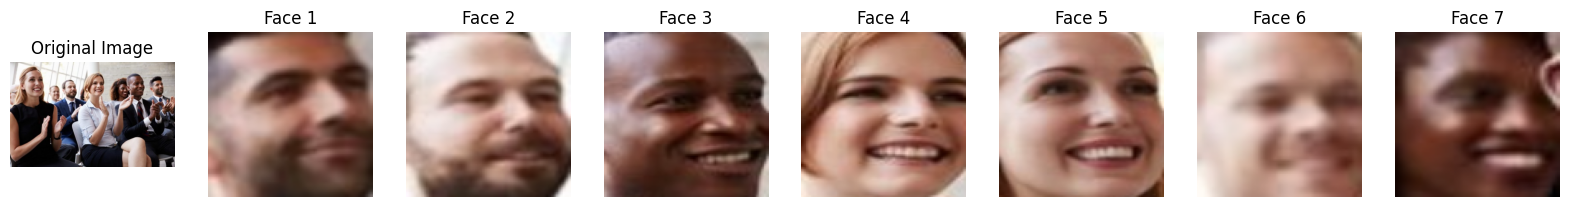

In [42]:
from mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt

def extract_faces_mtcnn(image_path, target_size=(100, 100)):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    detector = MTCNN()
    results = detector.detect_faces(image_rgb)

    if not results:
        print("No faces detected!")
        return None, image_rgb

    faces = []
    for result in results:
        x, y, width, height = result["box"]
        x, y = max(0, x), max(0, y)  # Ensure coordinates stay within bounds
        face = image_rgb[y:y+height, x:x+width]
        face_resized = cv2.resize(face, target_size)
        faces.append(face_resized)

    return faces, image_rgb

# Test on an image
image_path = "t.JPG"
faces, original_image = extract_faces_mtcnn(image_path)

if faces:
    plt.figure(figsize=(20, 10))
    
    # Display the original image
    plt.subplot(1, len(faces) + 1, 1)
    plt.imshow(original_image)
    plt.axis("off")
    plt.title("Original Image")

    # Display extracted faces
    for i, face in enumerate(faces):
        plt.subplot(1, len(faces) + 1, i + 2)
        plt.imshow(face)
        plt.axis("off")
        plt.title(f"Face {i+1}")

    plt.show()
else:
    print("No faces detected!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


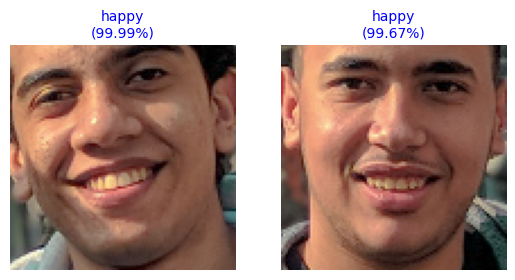

In [43]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the trained model
cnn_model = load_model("best_model122.h5")

# Emotion class dictionary
class_dict = {1: "surprise",2:"unsatisfied",3: "happy", 4: "unsatisfied", 5: "angry", 6: "neutral"}
# Load the face detection model from Mediapipe
mp_face_detection = mp.solutions.face_detection

#  Function to extract faces from an image
def extract_faces(image_path, target_size=(100, 100)):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    
    with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detector:
        results = face_detector.process(image_rgb)

        if not results.detections:
            print("No faces detected!")
            return []

        faces = []
        for detection in results.detections:
            bboxC = detection.location_data.relative_bounding_box
            h, w, _ = image.shape

            #  Extract face coordinates
            x_min = int(bboxC.xmin * w)
            y_min = int(bboxC.ymin * h)
            box_width = int(bboxC.width * w)
            box_height = int(bboxC.height * h)

            #  Crop the face
            face = image_rgb[y_min:y_min + box_height, x_min:x_min + box_width]
            if face.shape[0] > 0 and face.shape[1] > 0:  # Ensure the face is valid
                face_resized = cv2.resize(face, target_size)  # Resize for the model
                faces.append(face_resized)

        return faces

#  Function to analyze emotions for each detected face
def predict_emotions(faces):
    emotions = []
    for face in faces:
        face_array = img_to_array(face)
        face_array = np.expand_dims(face_array, axis=0)  # Convert image to 4D
        face_array = face_array / 255.0  # Normalize pixel values

        #  Perform emotion prediction
        prediction = cnn_model.predict(face_array)

        #  Extract the most probable emotion
        emotion_label = np.argmax(prediction) + 1
        predicted_emotion = class_dict.get(emotion_label, "Unknown")
        confidence = prediction[0][emotion_label - 1] * 100  # Convert confidence to percentage

        emotions.append((predicted_emotion, confidence))
    
    return emotions

#  Test: Extract faces and analyze emotions
image_path = "1.jpg"
faces = extract_faces(image_path)

if faces:
    emotions = predict_emotions(faces)

    for i, (face, (emotion, confidence)) in enumerate(zip(faces, emotions)):
        plt.subplot(1, len(faces), i + 1)
        plt.imshow(face)
        plt.axis("off")
        plt.title(f"{emotion}\n({confidence:.2f}%)", fontsize=10, color="blue")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


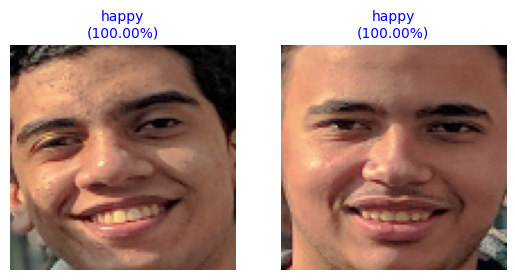

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mtcnn import MTCNN
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the trained model
cnn_model = load_model("best_model122.h5")

# Emotion class dictionary
class_dict = {1: "surprise",2:"unsatisfied",3: "happy", 4: "unsatisfied", 5: "angry", 6: "neutral"}

#  Load MTCNN for face detection
detector = MTCNN()

#  Function to extract faces using MTCNN
def extract_faces(image_path, target_size=(100, 100)):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    
    results = detector.detect_faces(image_rgb)

    if not results:
        print("No faces detected!")
        return []

    faces = []
    for result in results:
        x, y, width, height = result["box"]

        #  Ensure positive values
        x, y = max(0, x), max(0, y)

        # Crop the face
        face = image_rgb[y:y + height, x:x + width]
        if face.shape[0] > 0 and face.shape[1] > 0:  # Ensure valid face
            face_resized = cv2.resize(face, target_size)  # Resize for model
            faces.append(face_resized)

    return faces

#  Function to analyze emotions for each detected face
def predict_emotions(faces):
    emotions = []
    for face in faces:
        face_array = img_to_array(face)
        face_array = np.expand_dims(face_array, axis=0)  # Convert image to 4D
        face_array = face_array / 255.0  # Normalize pixel values

        #  Perform emotion prediction
        prediction = cnn_model.predict(face_array)

        #  Extract the most probable emotion
        emotion_label = np.argmax(prediction) + 1
        predicted_emotion = class_dict.get(emotion_label, "Unknown")
        confidence = prediction[0][emotion_label - 1] * 100  # Convert confidence to percentage

        emotions.append((predicted_emotion, confidence))
    
    return emotions

#  Test: Extract faces and analyze emotions
image_path = "1.jpg"
faces = extract_faces(image_path)

if faces:
    emotions = predict_emotions(faces)

    for i, (face, (emotion, confidence)) in enumerate(zip(faces, emotions)):
        plt.subplot(1, len(faces), i + 1)
        plt.imshow(face)
        plt.axis("off")
        plt.title(f"{emotion}\n({confidence:.2f}%)", fontsize=10, color="blue")

    plt.show()


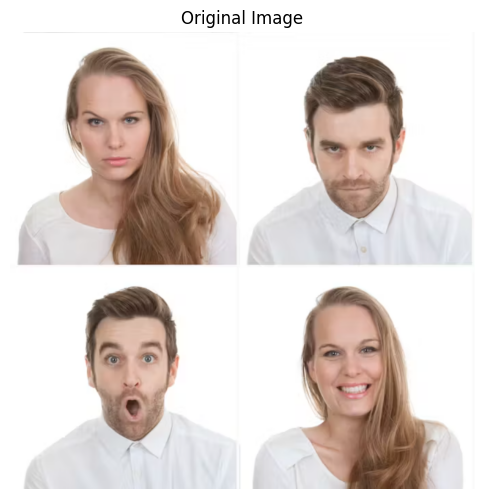

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


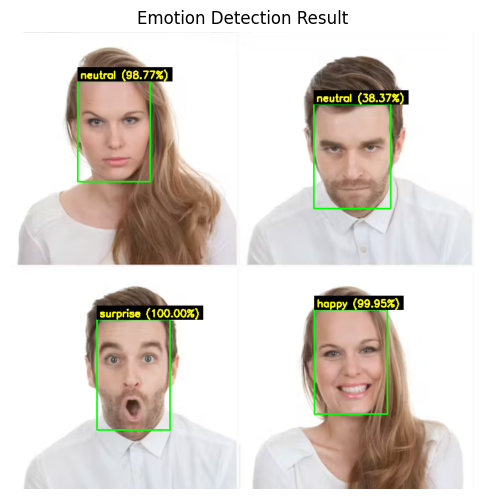

In [7]:
import cv2
import numpy as np
from mtcnn import MTCNN
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

# Load the trained model
cnn_model = load_model("best_model122.h5")

# Emotion class dictionary
class_dict = {1: "surprise", 2: "unsatisfied", 3: "happy", 4: "unsatisfied", 5: "angry", 6: "neutral"}

# Load MTCNN for face detection
detector = MTCNN()

# Preprocess face
def preprocess_face(face):
    try:
        face = cv2.resize(face, (100, 100))
        face = img_to_array(face)
        face = np.expand_dims(face, axis=0)
        face = face / 255.0
        return face
    except Exception as e:
        print(f"Error processing face: {e}")
        return None

# Load the image
image_path = "test.png"  
frame = cv2.imread(image_path)

# Convert BGR to RGB for display
original_rgb = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB)

#Show original image
plt.figure(figsize=(6, 6))
plt.title("Original Image")
plt.imshow(original_rgb)
plt.axis("off")
plt.show()

# Convert to RGB for MTCNN
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Detect faces
results = detector.detect_faces(frame_rgb)

if results:
    for result in results:
        x, y, width, height = result["box"]
        x = np.clip(x, 0, frame.shape[1])
        y = np.clip(y, 0, frame.shape[0])
        width = np.clip(width, 0, frame.shape[1] - x)
        height = np.clip(height, 0, frame.shape[0] - y)

        face = frame[y:y+height, x:x+width]

        if face.shape[0] > 10 and face.shape[1] > 10:
            processed_face = preprocess_face(face)

            if processed_face is not None:
                prediction = cnn_model.predict(processed_face)
                emotion_label = np.argmax(prediction) + 1
                predicted_emotion = class_dict.get(emotion_label, "Unknown")
                confidence = prediction[0][emotion_label - 1] * 100

                # Draw rectangle and label
                cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0), 2)
                text = f"{predicted_emotion} ({confidence:.2f}%)"
                (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                cv2.rectangle(frame, (x, y - 25), (x + text_width + 10, y), (0, 0, 0), -1)
                cv2.putText(frame, text, (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

# Convert final result to RGB for display
result_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Show image after prediction
plt.figure(figsize=(6, 6))
plt.title("Emotion Detection Result")
plt.imshow(result_rgb)
plt.axis("off")
plt.show()


In [1]:
import cv2
import numpy as np
from mtcnn import MTCNN
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the trained model
cnn_model = load_model("best_model122.h5")

# Emotion class dictionary
class_dict = {1: "surprise",2:"unsatisfied",3: "happy", 4: "unsatisfied", 5: "angry", 6: "neutral"}

#  Load MTCNN for face detection
detector = MTCNN()

#  Preprocess face before passing it to the model
def preprocess_face(face):
    try:
        face = cv2.resize(face, (100, 100))  # Resize to match the model input
        face = img_to_array(face)
        face = np.expand_dims(face, axis=0)  # Convert to 4D
        face = face / 255.0  # Normalize values
        return face
    except Exception as e:
        print(f"Error processing face: {e}")
        return None

#  Start webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to RGB since MTCNN works with RGB images
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Detect faces
    results = detector.detect_faces(frame_rgb)
    
    if results:
        for result in results:
            x, y, width, height = result["box"]
            
            # Ensure coordinates stay within image bounds
            x = np.clip(x, 0, frame.shape[1])
            y = np.clip(y, 0, frame.shape[0])
            width = np.clip(width, 0, frame.shape[1] - x)
            height = np.clip(height, 0, frame.shape[0] - y)

            # Extract the detected face
            face = frame[y:y+height, x:x+width]
            
            if face.shape[0] > 10 and face.shape[1] > 10:  # Ensure face is not too small
                processed_face = preprocess_face(face)
                
                if processed_face is not None:
                    prediction = cnn_model.predict(processed_face)

                    #  Get the highest confidence label
                    emotion_label = np.argmax(prediction) + 1  # Add 1 to match class_dict
                    predicted_emotion = class_dict.get(emotion_label, "Unknown")
                    confidence = prediction[0][emotion_label - 1] * 100  # Convert confidence to percentage

                    #  Draw a rectangle around the face
                    cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 255, 0), 2)

                    #  Display emotion label and confidence with background for better visibility
                    text = f"{predicted_emotion} ({confidence:.2f}%)"
                    (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                    cv2.rectangle(frame, (x, y - 25), (x + text_width + 10, y), (0, 0, 0), -1)
                    cv2.putText(frame, text, (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    # Show the video stream
    cv2.imshow("Real-time Emotion Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):  # Press 'q' to exit
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

In [4]:
import cv2
import numpy as np
import json
import time
from mtcnn import MTCNN
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the trained model
cnn_model = load_model("best_model122.h5")

# Emotion class dictionary
class_dict = {1: "surprise", 2: "unsatisfied", 3: "happy", 4: "unsatisfied", 5: "angry", 6: "neutral"}

# Preprocess face before passing it to the model
def preprocess_face(face, target_size=(100, 100)):
    face = cv2.resize(face, target_size)
    face = img_to_array(face)
    face = np.expand_dims(face, axis=0)
    face = face / 255.0
    return face

# Analyze a single frame and detect emotions
def analyze_frame(frame):
    detector = MTCNN()
    results = detector.detect_faces(frame)
    
    if not results:
        return {}
    
    emotions_count = {emotion: 0 for emotion in class_dict.values()}
    total_faces = 0
    
    for result in results:
        x, y, width, height = result["box"]
        x, y = max(0, x), max(0, y)
        face = frame[y:y+height, x:x+width]
        processed_face = preprocess_face(face)
        prediction = cnn_model.predict(processed_face)
        emotion_label = np.argmax(prediction) + 1
        
        # تعديل هنا: إذا كانت النتيجة 2 أو 4، خليها "unsatisfied"
        if emotion_label == 2 or emotion_label == 4:
            predicted_emotion = "unsatisfied"
        else:
            predicted_emotion = class_dict.get(emotion_label, "Unknown")
        
        emotions_count[predicted_emotion] += 1
        total_faces += 1
    
    if total_faces > 0:
        for emotion in emotions_count:
            emotions_count[emotion] = round((emotions_count[emotion] / total_faces) * 100, 2)
    
    return emotions_count

# Main function for real-time emotion analysis
def main():
    cap = cv2.VideoCapture(0)
    event_emotions = []
    start_time = time.time()
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        current_time = time.time()
        if (current_time - start_time) >= 300:  # Every 5 minutes
            emotions_data = analyze_frame(frame)
            if emotions_data:
                event_emotions.append(emotions_data)
                print(f"📸 Captured and analyzed a new frame!")
            start_time = current_time
        
        cv2.imshow("Live Feed", frame)
        if cv2.waitKey(1) & 0xFF == ord("q"): # press "q" to exit camera
            break
    
    cap.release()
    cv2.destroyAllWindows()
    
    # Calculate the final report
    final_report = {emotion: 0 for emotion in class_dict.values()}
    
    if event_emotions:
        for data in event_emotions:
            for emotion in data:
                final_report[emotion] += data[emotion]
        
        for emotion in final_report:
            final_report[emotion] = round(final_report[emotion] / len(event_emotions), 2)

    # Determine the dominant emotion
    dominant_emotion = max(final_report, key=final_report.get)

    # Convert values to percentages with '%'
    final_report = {emotion: f"{value:.2f}%" for emotion, value in final_report.items()}

    # Save the final report
    report = {
        "event_summary": {
            "dominant_emotion": dominant_emotion
        },
        "emotion_distribution": final_report
    }
    
    with open("event_emotions.json", "w") as f:
        json.dump(report, f, indent=4)
    
    print("Final report saved to event_emotions.json")

if __name__ == "__main__":
    main()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
📸 Captured and analyzed a new frame!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
📸 Captured and analyzed a new frame!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
📸 Captured and analyzed a new frame!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
📸 Captured and analyzed a new frame!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
📸 Captured and analyzed a new frame!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
📸 Captured and analyzed a new frame!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
📸 Captured and analyzed a new frame!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
📸 Captured and analyzed a new frame!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
📸 Captured and analyzed a new frame!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
📸 Captured and analyzed a new frame!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
📸 Captured and analyzed a new frame!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
📸 Captured and analyzed a new frame!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
📸 Captured and analyzed a new frame!
1/1 ━━━━━━━━━━━━━━━━━━━━

In [150]:
import tensorflow as tf
print(tf.keras.__version__)

3.8.0
